### Do some investigative work on whether looking at feature attention is feasible with a decoding method
Ask: Can selected features be decoded better/earlier when attended to?
- Define attended to: feature that is max valued in the behavior model, AND monkey chooses that feature


### Load data: 

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns

In [3]:
num_bins = 10

def get_sess_beh(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
    beh = behavioral_utils.get_relative_block_position(beh, num_bins)
    beh = behavioral_utils.get_max_feature_value(beh, num_bins)
    beh = behavioral_utils.calc_feature_probs(beh)
    beh = behavioral_utils.calc_feature_value_entropy(beh, num_bins, quantize_bins=True)
    beh["session"] = session
    return beh

In [4]:
# Monkey S
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
res = pd.concat(sessions.apply(lambda x: get_sess_beh(x, beh_path), axis=1).values)
res["CombinedIdx"] = np.arange(len(res))


### What is the proportion of trials where the highest valued feature is also chosen? (model probably get it right)

In [5]:
def get_max_feat_chosen(row):
    dim = FEATURE_TO_DIM[row.MaxFeat]
    return row[dim] == row.MaxFeat
res["MaxFeatChosen"] = res.apply(get_max_feat_chosen, axis=1)

In [6]:
len(res[res.MaxFeatChosen]) / len(res)

0.6186413450897797

<Axes: xlabel='FeatEntropyBin', ylabel='ProbMaxFeatChosen'>

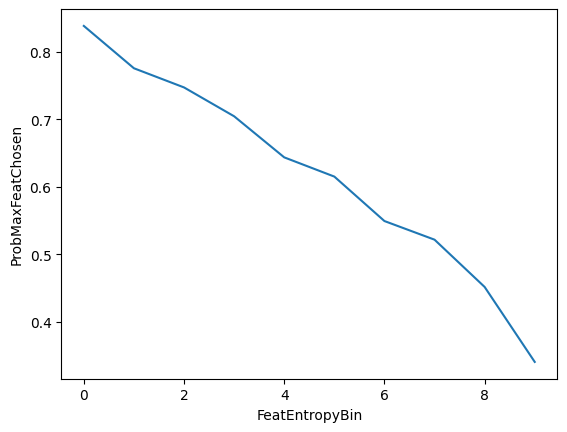

In [7]:
def calc_prob_max_feat_chosen(group):
    return len(group[group.MaxFeatChosen]) / len(group)
prob_max_feat_chosen = res.groupby("FeatEntropyBin", group_keys=False).apply(calc_prob_max_feat_chosen).reset_index(name='ProbMaxFeatChosen')
sns.lineplot(prob_max_feat_chosen, x="FeatEntropyBin", y="ProbMaxFeatChosen")

### Per session, per feature, print number of trials, number of unique blocks we have of each feature

In [8]:
sub_res = res[res.MaxFeatChosen]

In [9]:
num_feats = sub_res.groupby(["session"]).MaxFeat.nunique()
sessions = num_feats[num_feats == 12].index
res = sub_res[sub_res.session.isin(sessions)].groupby(["session", "MaxFeat"]).TrialNumber.nunique().reset_index()

<Axes: >

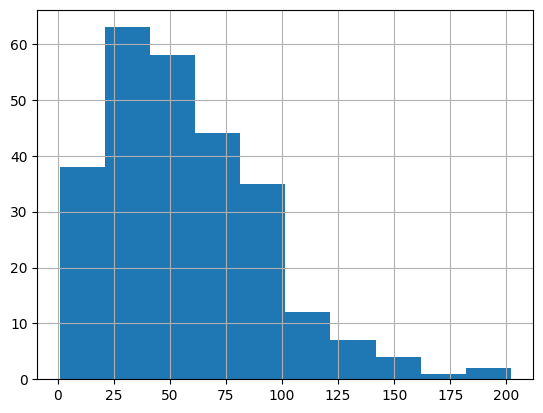

In [10]:
res.TrialNumber.hist()

### For each feature dimension, how many sessions have at least 2 blocks of each feature in that dim

In [11]:
# valid_sessions_per_dim = 
dfs = []
for dim in FEATURE_DIMS:
    feats = POSSIBLE_FEATURES[dim]
    sub_res_dim = sub_res[sub_res.MaxFeat.isin(feats)]
    def check(group):
        has_all_feats = group.MaxFeat.nunique() == 4
        blocks_per_feat = group.groupby("MaxFeat").BlockNumber.nunique()
        enough_blocks = np.all(blocks_per_feat >= 2)
        return has_all_feats and enough_blocks
    res = sub_res_dim.groupby("session").apply(check)
    dfs.append(pd.DataFrame({"dim": dim, "session": res[res].index}))
valid_sessions = pd.concat(dfs)

### Per dim/session, conditions of interest: feature (ex. CYAN, MAGENTA etc) and whether feature was max valued

In [12]:
valid_sessions

,dim,session
0,Color,20180705
1,Color,201807250001
2,Color,20180801
3,Color,20180802
4,Color,20180803
...,...,...
18,Pattern,20181002
19,Pattern,20181003
20,Pattern,20181008
21,Pattern,20181009


### At least How many trials are in each session/dimension/condition?

In [36]:
res = []
for i, row in valid_sessions.iterrows():
    feats = POSSIBLE_FEATURES[row.dim]
    session = row.session
    # find min num trials between: each feature in the dim, when feature is max feat or when not. 
    max_feat_sub_res = sub_res[
        (sub_res.MaxFeat.isin(feats)) &
        (sub_res.session == session)
    ]
    min_max_feat = max_feat_sub_res.groupby(row.dim).TrialNumber.nunique().min()
    not_max_feat_sub_res = sub_res[
        (~sub_res.MaxFeat.isin(feats)) &
        (sub_res.session == session)
    ] 
    min_not_max_feat = not_max_feat_sub_res.groupby(row.dim).TrialNumber.nunique().min()
    row["MinTrialsPerCond"] = np.min([min_max_feat, min_not_max_feat])
    res.append(row)
res = pd.DataFrame(res)

### Save session/dim mappings that have at least 15 trials per cond

In [46]:
at_least_15 = res[res.MinTrialsPerCond >= 15]

In [47]:
at_least_15.groupby("dim").session.nunique()

dim
Color      16
Pattern    19
Shape      18
Name: session, dtype: int64

In [48]:
at_least_15.to_pickle("/data/patrick_res/sessions/valid_sessions_by_dim.pickle")

In [49]:
at_least_15

,dim,session,MinTrialsPerCond
1,Color,201807250001,19
2,Color,20180801,15
3,Color,20180802,55
4,Color,20180803,30
5,Color,20180806,30
7,Color,20180912,54
8,Color,20180918,35
10,Color,20180921,57
11,Color,20180924,27
12,Color,20180925,32
